<a href="https://colab.research.google.com/github/ruth22soft/-OpenCog_Hyperon_Exercises/blob/main/variational_quantum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install required packages if not present
!pip install pennylane torch torchvision scikit-learn matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 72.0 MB/s eta 0:00:00


Explained variance (4 PCs): 0.733548865390202
Shapes: (142, 4) (36, 4)
Epoch   1  loss=1.1839  train_acc=0.3099
Epoch  20  loss=1.1491  train_acc=0.3169
Epoch  40  loss=1.1157  train_acc=0.2535
Epoch  60  loss=1.0853  train_acc=0.3169
Epoch  80  loss=1.0570  train_acc=0.4789
Epoch 100  loss=1.0292  train_acc=0.5915
Epoch 120  loss=1.0010  train_acc=0.5845
Test accuracy (hybrid): 0.6111111111111112
Confusion matrix:
 [[10  2  0]
 [ 2 12  0]
 [ 7  3  0]]
Baseline test acc: 0.8055555555555556


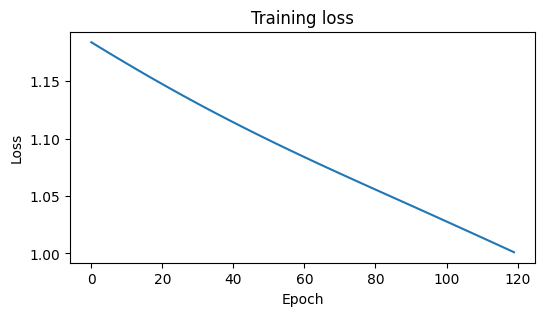

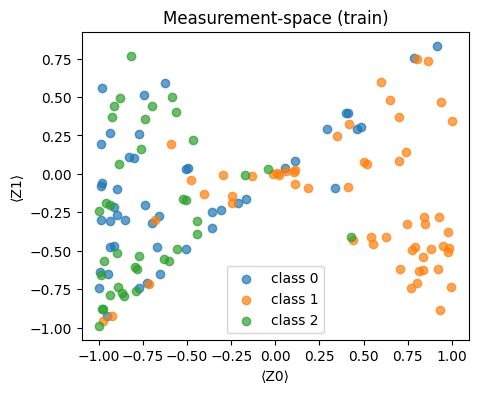

In [22]:
# install if needed:
# pip install pennylane torch scikit-learn matplotlib

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pennylane as qml
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# reproducibility
np.random.seed(42)
torch.manual_seed(42)

# --- 1) Load + preprocess (PCA -> 4 features) ---
data = load_wine()
X, y = data.data, data.target    # (178,13), 3 classes
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s  = scaler.transform(X_test)

pca = PCA(n_components=4, random_state=42).fit(X_train_s)
X_train_p = pca.transform(X_train_s)   # shape (n_train, 4)
X_test_p  = pca.transform(X_test_s)

print("Explained variance (4 PCs):", pca.explained_variance_ratio_.sum())
print("Shapes:", X_train_p.shape, X_test_p.shape)

# convert to torch tensors
X_train_t = torch.tensor(X_train_p, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t  = torch.tensor(X_test_p, dtype=torch.float32)
y_test_t  = torch.tensor(y_test, dtype=torch.long)

# --- 2) Quantum device + QNode (torch-native simulator) ---
n_qubits = 4
dev = qml.device("lightning.qubit", wires=n_qubits)

# dev = qml.device("default.qubit.torch", wires=n_qubits)  # <- FIXED

L = 1

def feature_map(x):
    for i in range(n_qubits):
        qml.RY(x[i], wires=i)
        qml.RZ(x[i], wires=i)

def ansatz(params):
    for layer in range(L):
        for i in range(n_qubits):
            qml.RY(params[layer, i], wires=i)
        for i in range(n_qubits-1):
            qml.CNOT(wires=[i, i+1])

# @qml.qnode(dev, interface="torch", diff_method="parameter-shift")   # <- use backprop on torch device
# def quantum_circuit(x, qparams):
#     feature_map(x)
#     ansatz(qparams)
#     # return a torch tensor directly
#     return torch.stack([qml.expval(qml.PauliZ(i)) for i in range(n_qubits)])
@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def quantum_circuit(x, qparams):
    feature_map(x)
    ansatz(qparams)
    # Return as a tuple of expectation values (Torch will handle it)
    return (qml.expval(qml.PauliZ(0)),
            qml.expval(qml.PauliZ(1)),
            qml.expval(qml.PauliZ(2)),
            qml.expval(qml.PauliZ(3)))


# # --- 2) Quantum device + QNode (torch interface) ---
# n_qubits = 4
# dev = qml.device("default.qubit", wires=n_qubits)  # statevector simulator is deterministic

# L = 1  # ansatz depth (start with 1)

# def feature_map(x, scale=1.0):
#     # x is a torch tensor length 4 (no conversion to numpy/float)
#     # use the tensor directly as rotation parameter
#     for i in range(n_qubits):
#         qml.RY(scale * x[i], wires=i)
#         qml.RZ(scale * x[i], wires=i)

# def ansatz(params):
#     # params is a torch tensor of shape (L, n_qubits)
#     for layer in range(L):
#         for i in range(n_qubits):
#             qml.RY(params[layer, i], wires=i)
#         # chain entangler
#         for i in range(n_qubits - 1):
#             qml.CNOT(wires=[i, i + 1])

# # QNode: interface='torch' lets us pass torch tensors directly and get torch tensors back
# @qml.qnode(dev, interface='torch', diff_method='parameter-shift')
# def quantum_circuit(x, qparams):
#     # x: torch tensor (4,)
#     # qparams: torch tensor (L, n_qubits)
#     feature_map(x, scale=1.0)
#     ansatz(qparams)
#     # return a single tensor of shape (n_qubits,)
#     return qml.math.stack([qml.expval(qml.PauliZ(i)) for i in range(n_qubits)])

# --- 3) Classical head (PyTorch) ---
class ClassicalHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(n_qubits, 8)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(8, 3)  # 3 classes

    def forward(self, x):
        x = self.relu(self.fc1(x))
        return self.fc2(x)

head = ClassicalHead()
# quantum params as torch Parameter
qparams = torch.nn.Parameter(0.1 * torch.randn(L, n_qubits, requires_grad=True))

# optimizer handles both classical and quantum params
optimizer = optim.Adam([{'params': head.parameters()}, {'params': [qparams]}], lr=1e-3)
criterion = nn.CrossEntropyLoss()

# --- 4) Training loop (full-batch for simplicity) ---
epochs = 120
train_losses, train_accs = [], []

for epoch in range(epochs):
    head.train()
    optimizer.zero_grad()

    # Compute measurements for each training sample
    meas_list = []
    # Looping per sample is okay for small dataset (Wine). Each call returns torch.Tensor.
    for i in range(X_train_t.shape[0]):
        m = quantum_circuit(X_train_t[i], qparams)   # returns tuple of torch tensors
        meas_list.append(torch.stack(m).to(torch.float32)) # Stack and cast to float32
    meas = torch.stack(meas_list)  # shape (n_train, 4)

    logits = head(meas)            # shape (n_train, 3)
    loss = criterion(logits, y_train_t)
    loss.backward()
    optimizer.step()

    preds = torch.argmax(logits.detach(), dim=1).numpy()
    acc = accuracy_score(y_train, preds)
    train_losses.append(loss.item())
    train_accs.append(acc)

    if (epoch + 1) % 20 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}  loss={loss.item():.4f}  train_acc={acc:.4f}")

# --- 5) Evaluate on test set ---
head.eval()
meas_test = []
with torch.no_grad():
    for i in range(X_test_t.shape[0]):
        m = quantum_circuit(X_test_t[i], qparams) # returns tuple of torch tensors
        meas_test.append(torch.stack(m).to(torch.float32)) # Stack and cast to float32
meas_test = torch.stack(meas_test)
logits_test = head(meas_test)
pred_test = torch.argmax(logits_test, dim=1).numpy()
test_acc = accuracy_score(y_test, pred_test)
print("Test accuracy (hybrid):", test_acc)
print("Confusion matrix:\n", confusion_matrix(y_test, pred_test))

# --- 6) Baseline classical model (same classical head but operating on PCA features) ---
class BaselineNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 8)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(8, 3)
    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

baseline = BaselineNet()
opt_base = optim.Adam(baseline.parameters(), lr=1e-3)
for epoch in range(80):
    opt_base.zero_grad()
    logits_b = baseline(X_train_t)
    loss_b = criterion(logits_b, y_train_t)
    loss_b.backward()
    opt_base.step()

baseline.eval()
pred_b = torch.argmax(baseline(X_test_t).detach(), dim=1).numpy()
print("Baseline test acc:", accuracy_score(y_test, pred_b))

# --- 7) Quick plots ---
plt.figure(figsize=(6,3))
plt.plot(train_losses)
plt.title("Training loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.show()

# measurement scatter (first two measured qubits) colored by class
meas_all_tensor = torch.stack([torch.stack(quantum_circuit(X_train_t[i], qparams)).detach().to(torch.float32) for i in range(X_train_t.shape[0])])
meas_all = meas_all_tensor.numpy() # Convert to numpy once

plt.figure(figsize=(5,4))
for c in np.unique(y_train):
    idx = np.where(y_train==c)
    # Use the numpy array directly
    plt.scatter(meas_all[idx,0], meas_all[idx,1], label=f"class {c}", alpha=0.7)
plt.xlabel("⟨Z0⟩"); plt.ylabel("⟨Z1⟩"); plt.legend(); plt.title("Measurement-space (train)")
plt.show()

In [23]:
# 1. Compute quantum measurements for test set
meas_test = []
with torch.no_grad():
    for i in range(X_test_t.shape[0]):
        m = quantum_circuit(X_test_t[i], qparams)  # tuple
        meas_test.append(torch.tensor(m, dtype=torch.float32))
meas_test = torch.stack(meas_test)

# 2. Pass through classical head
logits_test = head(meas_test)
pred_test = torch.argmax(logits_test, dim=1).numpy()

# 3. Compute test accuracy
acc_test = accuracy_score(y_test, pred_test)
print("Test accuracy:", acc_test)


Test accuracy: 0.6111111111111112


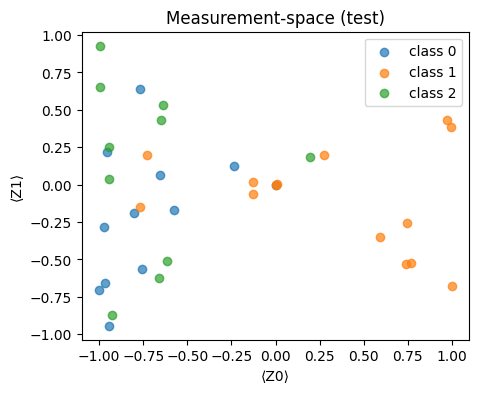

In [24]:
meas_test_numpy = meas_test.numpy()

plt.figure(figsize=(5,4))
for c in np.unique(y_test):
    idx = np.where(y_test==c)
    plt.scatter(meas_test_numpy[idx,0], meas_test_numpy[idx,1], label=f"class {c}", alpha=0.7)
plt.xlabel("⟨Z0⟩"); plt.ylabel("⟨Z1⟩"); plt.legend(); plt.title("Measurement-space (test)")
plt.show()